## Introduction to Quantum Machine Learning

Quantum Machine Learning is a field that aims to leverage the power of quantum computing and machine learning to solve complex tasks more efficiently. There are four different approaches to combining quantum computing and machine learning, differentiated by whether the data is classical (C) or quantum (Q), or whether the algorithm runs on a classical (C) or quantum (Q) computer.

#### CC
CC refers to processing Classical data using Classical computers, but using algorithms inspired by quantum computing.

#### CQ
CQ refers to processing Classical data using Quantum machine learning algorithms, and will be what this chapter focuses on.

#### QC
QC refers to processing Quantum data using Classical machine learning algorithms. This is an active area of investigation, with classical machine learning algorithms used in many areas in the quantum computing, such as qubit characterization, control and readout.

#### QQ
QQ refers to processing Quantum data using Quantum machine learning algorithms. This is an interesting topic, but very much still in its infancy.


 This notebook tackles Paremetrized Quantum Circuits which have emerged as a leading strategy to overcome today's noisy and error-prone quantum computers. PQCs utilize a classical optimizer and as such belong to the class CQ.

 The notebook is organized into the following sections:
1. Data Encoding
2. Parametrized Quantum Circuits (Models)
3. Training and Optimization

## Section 1: Data Encoding

The first step before building any machine learning model is data representation. To solve a particular task on a computer, it is essential to make it first presentable in a machine understandable format so that it can be ideally processed by the model. The question then arises: how to efficiently input this data into a quantum system so that it can be processed by a quantum machine learning algorithm.

Let's consider a classical dataset $\mathscr{X}$ consisting of $M$ samples, each with $N$ features:

$$
\mathscr{X} = \{ x^{(1)}, \dots, x^{(m)}, \dots, x^{(M)} \}
$$

where $x^{(m)}$ is an $N$ dimensional vector for $m = 1, ..., M$. We can represent this dataset in a qubit system, by using various embedding techniques, some of which are briefly explained and implemented below, as per References [1](#References) and  [2](#References).


### Basis encoding

Basis encoding associates a classical $N$-bit string with a computational basis state of an $N$-qubit system. Thus, the first step is to represent all data in the from of bitstrings. For example, if $x$ corresponds to the integer number $5$, this can be represented as a 4-bit string as $0101$, and by a 4-qubit system as the quantum state $|0101\rangle$. 

For the classical dataset $\mathscr{X}$ described above, to use basis encoding, each data point must be an $N$-bit string: $x^{(m)} = (b_1, b_2, \dots, b_N)$, which can then be mapped directly to the quantum state $|x^{(m)}\rangle = |b_1, b_2, \dots, b_N \rangle$ with $b_n \in \{0, 1\}$ for $n = 1, \dots, N$ and $m = 1, \dots, M$. We can represent the entire dataset as a superposition of computational basis states:

$$
| \mathscr{X} \rangle = \frac{1}{\sqrt{M}} \sum_{m=1}^{M} |x^{(m)} \rangle
$$

Here's a quick breakdown of the above formula:
1. The sum represents our data points each encoded as a seperate basis state after obtaining its binary representation
2. The rest of the basis states are set to 0
3. Since we have $M$ different data points we normalize the state by multiplying the linear combination of basis states by the factor $\frac{1}{\sqrt{M}}$


In Qiskit, once we calculate the state to encode our dataset, we can use the `initialize` function to prepare it. For example, the dataset $\mathscr{X} = \{x^{(1)}=101, x^{(2)}=111\}$ is encoded as the state $|\mathscr{X}\rangle = \frac{1}{\sqrt{2}}(|101\rangle + |111\rangle)$.


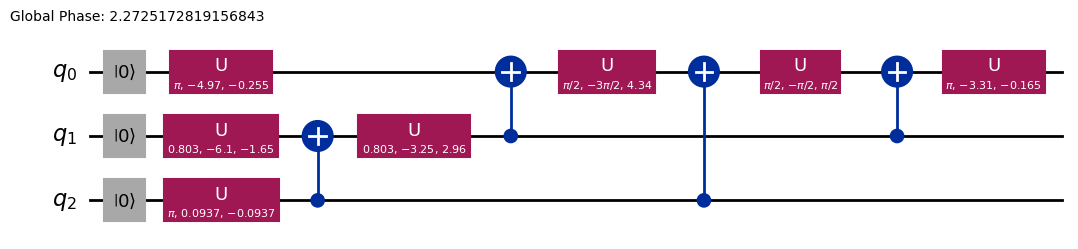

In [61]:
import math
from qiskit import QuantumCircuit

desired_state = [
    0,
    0,
    0,
    0,
    0,
    1 / math.sqrt(2),
    0,
    1 / math.sqrt(2)]

qc = QuantumCircuit(3)
qc.initialize(desired_state, [0,1,2])
qc.decompose().decompose().decompose().decompose().decompose().draw('mpl')

As seen from the above example, it can be quite difficult to find a circuit to implement these encodings. Additionally, the state vectors are usually sparse (most basis states are initialized to 0) meaning that we don't fully utilize the quantum state. Reference [3](#References) details methods that compilers use to prepare such states.

### Amplitude encoding

Amplitude encoding encodes data into the amplitudes of a quantum state. It represents a normalized classical $N$-dimensional data point, $x$, as the amplitudes of an $n$-qubit quantum state, $|\psi_x\rangle$:

$$
|\psi_x\rangle = \sum_{i=1}^N x_i |i\rangle
$$

where $N = 2^n$, $x_i$ is the $i^{\text{th}}$ element of $x$, and $|i\rangle$ is the $i^{\text{th}}$ computational basis state.

To encode the classical dataset $\mathscr{X}$ described above, we concatenate all $M$ $N$-dimensional data points into one amplitude vector, of length $N \times M$:

$$
\alpha = A_{\text{norm}}(x_{1}^{(1)}, ..., x_{N}^{(1)}, ..., x_{1}^{(m)}, ..., x_{N}^{(m)}, ..., x_{1}^{(M)}, ..., x_{N}^{(M)})
$$

where $A_{\text{norm}}$ is a normalization constant such that $|\alpha|^2 = 1$. The dataset $\mathscr{X}$ can now be represented in the computational basis as:

$$
|\mathscr{X}\rangle = \sum_{i=1}^N \alpha_i |i\rangle
$$

where $\alpha_i$ are elements of the amplitude vector, and $|i\rangle$ are the computational basis states. The number of amplitudes to be encoded is $N \times M$. Since a system of $n$ qubits provides $2^n$ amplitudes, amplitude encoding requires $n \ge \log_2(NM)$ qubits.

As an example, let's encode the dataset $\mathscr{X} = \{x^{(1)} = (1.5, 0), x^{(2)} = (-2, 3)\}$ using amplitude encoding. Concatenating both data points and normalizing the resulting vector, we get:

$$
\alpha = \frac{1}{\sqrt{15.25}} (1.5, 0, -2, 3)
$$

and the resulting 2-qubit quantum state would be:

$$
|\mathscr{X}\rangle = \frac{1}{\sqrt{15.25}} (1.5 |00\rangle - 2 |10\rangle + 3 |11\rangle)
$$

In the example above, the total number of elements in the amplitude vector, $N \times M$, is a power of 2. When $N \times M$ is not a power of 2, we can simply choose a value for $n$ such that $2^n \ge MN$ and pad the amplitude vector with uninformative constants.

This time we will use the `StatePreparation` class to prepare it.


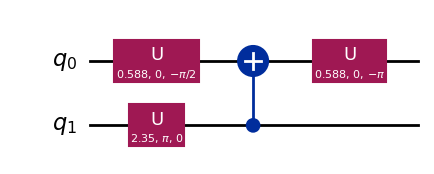

In [62]:
# Using the state preperation class to prepate the state

from qiskit.circuit.library import StatePreparation

# StatePreparatiom yields a gate which is the unitary transformation corresponding to the state
state_prep = StatePreparation(params=[1.5,0,-2,3], normalize=True)

qc = QuantumCircuit(2)

# We append the state_prep unitary to the quantum circuit
qc.append(state_prep, [0,1])

qc.decompose().decompose().decompose().decompose().draw('mpl')

### Angle encoding

Angle encoding encodes $N$ features into the rotation angles of $n$ qubits, where $N \le n$. For example, the data point $x = (x_1, \dots, x_N)$ can be encoded as follows:

1. Initialize $N$ qubits for each of the different features of our data point
2. Select a rotation gate either $RX$, $RY$, $RZ$
3. Set the angle of rotation of qubit $i$ to its corresponding data feature value

This method is different from the previous two encoding methods, as it encodes only one data point at a time rather than a whole dataset. However, it requires only $N$ qubits or fewer and a constant-depth quantum circuit, making it feasible for current quantum hardware.

As an example, we can encode the data point $x = (0, \pi/4, \pi/2)$ using Qiskit.


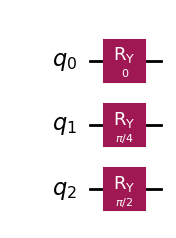

In [63]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(math.pi/4, 1)
qc.ry(math.pi/2, 2)
qc.draw('mpl')

## Section 2: Constructing the model

The next step in our machine learning process is to define the model architecture. We do this by allowing for tunable parameters inside the gates of our quantum circuit. These parameters start randomly, and via optimization later yield a circuit capable of solving the given task.

We will create a simple parameterized circuit, with two parameterized gates, a single-qubit $y$-rotation gate, with a variable rotation $\theta$, followed by a two-qubit controlled $z$-rotation gate, with the same variable rotation $\theta$. We can use the `Parameter` class whcich lets us add rotation gates, without having to specify what the angles are yet.

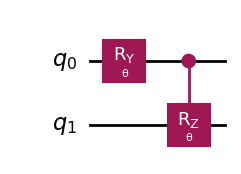

In [64]:
from qiskit.circuit import QuantumCircuit, Parameter
theta = Parameter('θ')

qc = QuantumCircuit(2)
qc.ry(theta, 0)
qc.crz(theta, 0, 1)
qc.draw('mpl')

If we want the gates to have different parameters, we can create two `Parameters`, or better yet a `ParameterVector`, which is like a list of `Parameters`:

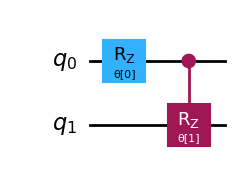

In [65]:
from qiskit.circuit import ParameterVector
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.draw('mpl')

How do we choose one parameterized circuit over the other? To use parameterized quantum circuits as a machine learning model, we need them to generalize well. This means that the circuit should be able to generate a significant subset of the states within the output Hilbert space. To avoid being easy to simulate on a classical computer, the circuit should also entangle qubits. 

In Reference [4](#References), the authors propose the measures of *expressibility* and *entangling capability* to discriminate between different parameterized quantum circuits. We can think of the *expressibility* of a circuit as the extent to which it can generate states within the Hilbert space, while the *entangling capability* of a circuit describes its ability to generate entangled states.

Let's compare the two following single-qubit circuits to get a sense of what it means for a circuit to be expressible or not, by sampling 2000 output states for each circuit and plotting them on a Bloch sphere. 

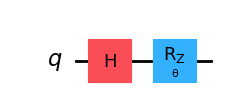

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# First, we need to define the circuits:
theta_param = Parameter('θ')
phi_param = Parameter('Φ')

# Circuit A
qc_A = QuantumCircuit(1)
qc_A.h(0)
qc_A.rz(theta_param, 0)
qc_A.draw('mpl')


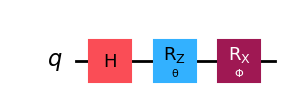

In [67]:

# Circuit B
qc_B = QuantumCircuit(1)
qc_B.h(0)
qc_B.rz(theta_param, 0)
qc_B.rx(phi_param, 0)
qc_B.draw('mpl')


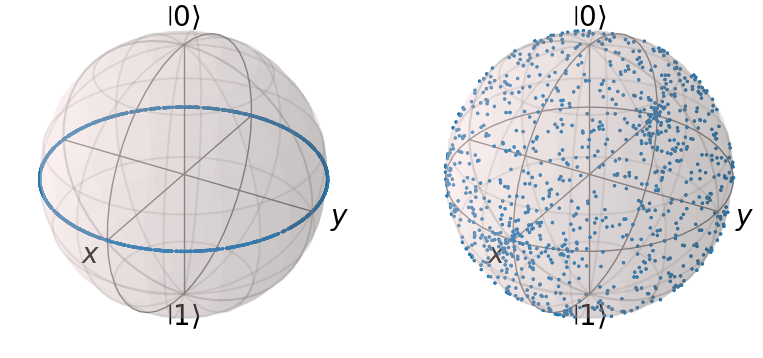

In [68]:

# Next we uniformly sample the parameter space for the two parameters theta and phi
np.random.seed(0)
num_param = 1000
theta = [2*np.pi*np.random.uniform() for i in range(num_param)]
phi = [2*np.pi*np.random.uniform() for i in range(num_param)]

# Then we take the parameter value lists, build the state vectors corresponding
# to each circuit, and plot them on the Bloch sphere:
from qiskit.visualization.bloch import Bloch
from qiskit.quantum_info import Statevector

def state_to_bloch(state_vec):
    # Converts state vectors to points on the Bloch sphere
    phi = np.angle(state_vec.data[1])-np.angle(state_vec.data[0])
    theta = 2*np.arccos(np.abs(state_vec.data[0]))
    return [np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)]

# Bloch sphere plot formatting
width, height = plt.figaspect(1/2)
fig=plt.figure(figsize=(width, height))
ax1, ax2 = fig.add_subplot(1, 2, 1, projection='3d'), fig.add_subplot(1, 2, 2, projection='3d')
b1,b2 = Bloch(axes=ax1), Bloch(axes=ax2)
b1.point_color, b2.point_color = ['tab:blue'],['tab:blue']
b1.point_marker, b2.point_marker= ['o'],['o']
b1.point_size, b2.point_size=[2],[2]

# Calculate state vectors for circuit A and circuit B for each set of sampled parameters
# and add to their respective Bloch sphere
for i in range(num_param):    
    state_1=Statevector.from_instruction(qc_A.assign_parameters({theta_param:theta[i]}))
    state_2=Statevector.from_instruction(qc_B.assign_parameters({theta_param:theta[i], phi_param:phi[i]}))
    b1.add_points(state_to_bloch(state_1))
    b2.add_points(state_to_bloch(state_2))

b1.show()
b2.show()

Thus, to ensure that our model is both expressive and has sufficient entangling capability, we start with a layer of a general qubit rotation (usually implemented as multiple rotation gates) then a layer of 2 qubit gates. It is also recommended to repeat these layers multiple times successively. We can build such a circuit using the `TwoLocal` circuit in qiskit:

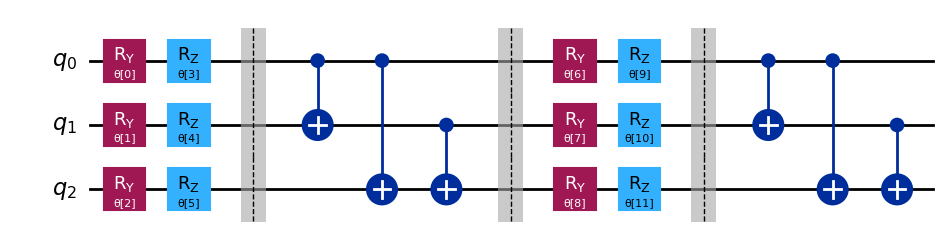

In [69]:
from qiskit.circuit.library import TwoLocal
qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'],
                entanglement_blocks='cx', entanglement = 'full',  skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw('mpl')


## Section 3: Training

Like classical models, we can train parameterized quantum circuit models to perform data-driven tasks. The task of learning an arbitrary function from data is mathematically expressed as the minimization of a cost or loss function $C(\vec\theta)$, also known as the objective function, with respect to the parameter vector $\vec\theta$. Generally, when training a parameterized quantum circuit model, the function we are trying to minimize is the expectation value:

$$
\langle \Psi(\vec\theta) | \hat{H} | \Psi(\vec\theta) \rangle
$$

where $\Psi(\vec\theta)$ is the final state of our quantum model.

There are many different types of algorithms that we can use to optimize the parameters of a variational circuit, $\mathbf{U_\theta}$, including gradient-based, evolutionary, and gradient-free methods. We will only be discussing gradient-based methods.

### Gradients

Say we have a function $f(\vec\theta)$, and we have access to the gradient of the function, $\vec{\nabla} f(\vec\theta)$, starting from an initial point. The simplest way to minimize the function is to update the parameters towards the direction of steepest descent of the function:

$$
\vec\theta_{n+1} = \vec\theta_n - \eta \vec{\nabla} f(\vec\theta)
$$

where $\eta$ is the learning rate - a small, positive hyperparameter controlling the size of the update. We continue doing this until we converge to a local minimum of the function, $f(\vec\theta^*)$.

This technique is called _gradient descent_ or _vanilla gradient descent_, since it's the plain gradient, without any special modifications.

Qiskit provides different methods to compute gradients of expectation values, so let's explore them!

First, we need to define our parameterized state, $|\Psi(\vec\theta)\rangle = U(\vec\theta)|00\dots 0\rangle$. In this example, $U(\vec\theta)$ is the following Qiskit `TwoLocal` circuit on two qubits.


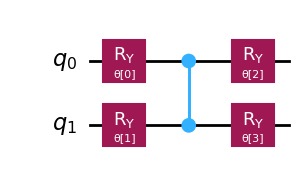

In [70]:
# Set up the TwoLocal circuit
ansatz = TwoLocal(num_qubits=2, reps=1, rotation_blocks='ry', 
                  entanglement_blocks='cz', entanglement='linear')
ansatz.decompose().draw('mpl')

Next we need to define a Hamiltonian, let's use: $\hat{H} = \hat{Z} \bigotimes \hat{Z}$


In [71]:
from qiskit.quantum_info import Pauli

hamiltonian = Pauli('ZZ')

Putting them together to make the expectation value: $\langle \Psi(\vec\theta) | \hat{H} | \Psi(\vec\theta) \rangle$

In [72]:
# Create a simulator backend
from qiskit.primitives import Estimator

estimator = Estimator()

# function to get the expectation value
def evaluate_expectation(theta):
    # Bind parameters to the circuit
    bound_circuit = ansatz.assign_parameters(theta)

    # Use the Estimator to compute the expectation value
    job = estimator.run(bound_circuit, hamiltonian)
    result = job.result()
    print(result.values[0].real)
    return result.values[0].real

C:\Users\youss\AppData\Local\Temp\ipykernel_16924\2228497789.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


To make things concrete, let's fix a point **p** and an index **i** and ask: What's the derivative of the expectation value with respect to parameter **θᵢ** at point **p**?

$$
\frac{\partial}{\partial \theta_i} \langle \Psi(\vec\theta) | \hat{H} | \Psi(\vec\theta) \rangle \Bigg\vert_{\vec\theta = \vec p}
$$


In [73]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
print(point)
INDEX = 2

[0.81151847 0.47608399 0.52315599 0.25052059]


Now that we have the expectation value in order to minimize it, we need to be able to compute the derivative of the circuit. Fortunately, there exists an analytical way to easily evaluate this gradient. In general, this is fairly difficult as we have to do a manual calculation, but for circuit based gradients, Reference [5](#References) introduces a nice theoretical result that gives an easy formula for calculating gradients: The _parameter shift_ rule.

For a simple circuit consisting of only Pauli rotations, without any coefficients, then this rule says that the analytic gradient is:

$$
\frac{\partial f}{\partial\theta_{i}} = \frac{f(\vec{\theta} + \frac{\pi}{2} \vec{e}_{i}) - f(\vec{\theta} - \frac{\pi}{2} \vec{e}_{i})}{2}
$$

This essentially means that by shifting the parameters and then measuring the circuit we can obtain the gradient at that point. We obtain the gradient from the circuit itself!

Let's try calculate it by hand:

In [74]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(finite_difference)

-0.8480844467351244
0.8480844467351244
-0.8480844467351244


Instead of doing this manually, we can use Qiskit's `Gradient`

In [75]:
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

grad = ParamShiftEstimatorGradient(estimator)

grad.run(ansatz, hamiltonian, [point]).result().gradients[0][2]

-0.8480844467351244

We see that the calculated analytic gradient is fairly similar to the calculated finite difference gradient.

Now that we know to calculate gradients, let's try optimizing the expectation value!

First we fix an initial point for reproducibility.

In [76]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

Similar to how we had a function to evaluate the expectation value, we'll need a function to evaluate the gradient.

In [77]:
def evaluate_gradient(theta):
    return grad.run(ansatz, hamiltonian, [theta]).result().gradients[0]

We create an optimizer log class and use the qiskit `GradientDescent` optimizer:

In [78]:
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)

from qiskit_algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)

And now we start the optimization and plot the loss!

0.5693638415391995
0.5567726587618633
0.5439438593502774
0.5308802176291797
0.5175849332834528
0.5040616361239428
0.49031438926397675
0.47634769062140014
0.4621664726701672
0.44777610037598825
0.4331823672622316
0.4183914895650759
0.40341009845070774
0.3882452302820848
0.3729043149381639
0.35739516220449963
0.34172594627044744
0.3259051883847008
0.309941737737361
0.2938447506528922
0.27762366819400264
0.2612881922914397
0.2448482605286899
0.22831401972343357
0.21169579845911218
0.1950040787299489
0.17824946687108661
0.16144266395200868
0.14459443581602588
0.1277155829512675
0.11081691037924046
0.09390919774569695
0.07700316979519145
0.06010946740549533
0.04323861935099588
0.026401014955446944
0.009606877784198276
-0.0071337594856526465
-0.023811078891538884
-0.04041549959631913
-0.05693769878654503
-0.07336863097597951
-0.08969954564771904
-0.10592200318384903
-0.12202788904705542
-0.13800942619382578
-0.1538591857136246
-0.1695700957025299
-0.1851354483931677
-0.20054890557520122
-0.2

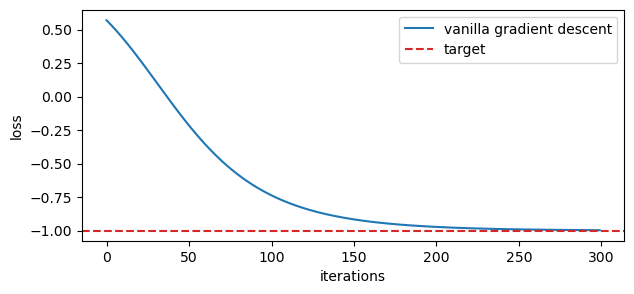

In [79]:
result = gd.minimize(
    fun=evaluate_expectation,  # function to minimize
    x0=initial_point,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

# References

1.  Maria Schuld and Francesco Petruccione, *Supervised Learning with Quantum Computers*, Springer 2018, [doi:10.1007/978-3-319-96424-9](https://www.springer.com/gp/book/9783319964232).
2. Ryan LaRose and Brian Coyle, *Robust data encodings for quantum classifiers*, Physical Review A 102, 032420 (2020), [doi:10.1103/PhysRevA.102.032420](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.032420), [arXiv:2003.01695](https://arxiv.org/abs/2003.01695).
3. Iten, Raban, et al. *Quantum circuits for isometries* Physical Review A 93.3 (2016): 032318. https://journals.aps.org/pra/abstract/10.1103/PhysRevA.93.032318
4. Sukin Sim, Peter D. Johnson and Alan Aspuru-Guzik, *Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms*,  	Advanced Quantum Technology 2 (2019) 1900070, [doi:10.1002/qute.201900070](https://onlinelibrary.wiley.com/doi/abs/10.1002/qute.201900070), [arXiv:1905.10876](https://arxiv.org/abs/1905.10876).
5. Maria Schuld, Ville Bergholm, Christian Gogolin, Josh Izaac and Nathan Killoran, *Evaluating analytic gradients on quantum hardware*, Physical Revview A 99, 032331 (2019), [doi:10.1103/PhysRevA.99.032331](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.032331), [arXiv:1811.11184](https://arxiv.org/abs/1811.11184).